# Level C
# Pick a dataset and objective

### Dataset:
- Dataset of Nifty Stock prices of Indian companies. ( https://www.kaggle.com/rohanrao/nifty50-stock-market-data  )

### Problem Statement:

- Creating an Algorithm to accept a filename as an input flag and automatically develop a Time Series Model to predict stock prices for it.


### Time Period
- Time period of the  year of 2008 using all previous data and for 2016 using data from 2009-2015.
    
    
    - You can start with a base algorithm choice like LSTM. However, the structure of this network should not be predefined.
    - This algorithm should automatically decide the structure of the network (no. of layers, no of neurons, etc) and hyperparameters to be used in the network
	- This algorithm should accept the name of the stock to be used as input (e.g. ICICIBANK.csv) in command line while running the program.
    - The algorithm should develop a model and save it as <stock_name>.h5 after optimizing the network configuration.
    - The algorithm should write the accuracy of the final algorithm to a file.


In [38]:
### Loading the libraries required

import pandas as pd       #Loading pandas for creating and adjusting dataframes 
import numpy as np        # Loading Numpy for creating and adjusting arrays

import matplotlib.pyplot as plt      # Loading matplotlib for visualizations
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler # Loading MinMaxScaler to scale the data

from sklearn.model_selection import GridSearchCV, KFold # Loading gridsearch CV for hyperparameter tuning using Crss Validation

from tensorflow.keras.layers import LSTM

from tensorflow.keras.models import Sequential     #Loading Sequential model from tensor flow to craete a LSTM model
from tensorflow.keras.layers import LSTM           #Loading LSTM model from tensor flow to craete a ANN model
from tensorflow.keras.layers import Dense          #Loading Dense layer from tensor flow to craete a Neural network layers
from tensorflow.keras.layers import Dropout        #Loading Drop out Layer

from tensorflow.keras.optimizers import Adam       #Loading Adam optimizer for LSTM

from sklearn.metrics import mean_squared_error     #Loading Mean Squared Error to to check the error metrics of the model 
from sklearn.metrics import mean_absolute_percentage_error  #Loading Mean absolute percentage error to to check the error metrics of the model 
from sklearn.metrics import r2_score       #Loading R^2 (R squared) to check the efficiency metrics of the model


In [39]:
# Get input from user of a file name
csv_file  = input("Enter CSV file name : ")
import os
#to get the current working directory
directory = os.getcwd()

print(directory)
#Reading the file name given as input
csv_file = csv_file.upper()
file_name = ("{}\\Nifty Stock prices of Indian companies\{}.csv".format(directory,csv_file))
df = pd.read_csv(file_name)

Enter CSV file name : icicibank
C:\Users\cricl\Documents\AIQ4\LEVEL C


In [40]:
# Preprocessing the data

def preprocessing(df,year):
    
    for i in '%Y-%m-%d', '%d-%m-%Y', '%m-%d-%Y':
        df["Date"] = pd.to_datetime(df.Date, format = i) #Converting the Date column to datetime fromat
        df["Year"] = pd.to_datetime(df.Date, format = i).dt.year # XCreating a Year Column in DF to split the data

    ### If year input in 2008
    # Create data between 2000 to 2008
    #Considering only DATE, Closea and Year Column
    
    if year == 2008:
        
        start_year = year-8
        end_year = year
        
        data = df.loc[df["Year"] <= year]
        
        data = data[["Date","Close","Year"]]
        data.set_index('Date', inplace=True)
        
    ### If year input is 2016
    # Create data between 2009 to 2016
    #Considering only DATE, Closea and Year Column
    
    if year == 2016:
        
        start_year = year-7
        end_year = year
    
        data = df[(df["Year"] <= end_year) & (df["Year"] >= start_year)]
        
        data = data[["Date","Close","Year"]]
        data.set_index('Date', inplace=True)
        
    
    # Create Test data and Train data as per inputs given (Input is Year)
    
    Train_data = data.loc[data["Year"] < end_year]
    Train_data = Train_data["Close"]
    Train_data = Train_data.to_frame()
    
    Test_data = data[(data["Year"] == end_year)]
    Test_data = Test_data["Close"]
    Test_data = Test_data.to_frame()
    
    return Train_data,Test_data,data

In [41]:
# Creating Train and Test data with the function created
Train_data = preprocessing(df,2008)[0]
Test_data = preprocessing(df,2008)[1]
data = preprocessing(df,2008)[2]

<AxesSubplot:xlabel='Date'>

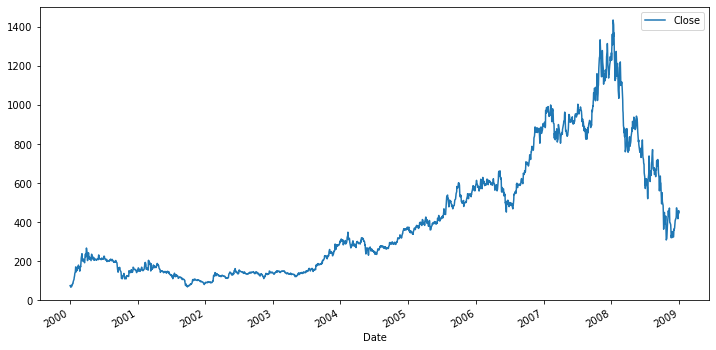

In [42]:
#Visualizing the Close column
data = data.drop(["Year"], axis = 1)
data.plot( y = "Close",figsize=(12,6))

In [43]:
# Scaling the data using MinMaxScaler and fit the tain and test data
scaler = MinMaxScaler(feature_range = (0,1))

scaled_array_train = scaler.fit_transform(Train_data)
scaled_array_test = scaler.fit_transform(Test_data)

In [44]:
# Creating the time series based on time step with the scaled data
## Time step provided is 90

def create_time_series(scaled_array,time_step):
    X = []
    Y = []
    time_step = time_step
    for i in range(time_step,len(scaled_array)):
        X.append(scaled_array[i-time_step:i,0])
        Y.append(scaled_array[i,0])
    
    
    X = np.array(X)
    Y = np.array(Y)
    
    return (X,Y)
    

In [45]:
#Creating X_train,Y_train,X_test,Y_test using the above created function

X_train = create_time_series(scaled_array_train,90)[0]
Y_train = create_time_series(scaled_array_train,90)[1]

X_test = create_time_series(scaled_array_test,90)[0]
Y_test = create_time_series(scaled_array_test,90)[1]


In [46]:
X_train_reshaped = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))

In [47]:
X_test_reshaped = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

### Hyperparameters all at once
- The hyperparameter optimization was carried out by taking 2 hyperparameters at once. We may have missed the best values. The performance can be further improved by finding the optimum values of hyperparameters all at once given by the code snippet below.

- This process is computationally expensive.

In [48]:
# Creating the function to optimize the Hyper parameters
# In this case learning_rate and dropout_rate

def optimize_params(X,Y):
    #creating model to use in the grid serach CV
    def create_model(learning_rate,dropout_rate):
        model = Sequential()
        model.add(LSTM(50, activation="relu",return_sequences =True, input_shape=(X_train.shape[1],1)))
        model.add(Dropout(0.2))

        model.add(LSTM(50, activation="relu",return_sequences =False))
        model.add(Dropout(0.2))

        model.add(Dense(1))
        adam = Adam(learning_rate = learning_rate)
        model.compile(optimizer=adam, loss='mse')
        return model

    # Create the model
    from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
    model = KerasRegressor(build_fn = create_model,verbose = 0,batch_size= 10,epochs = 3)

    # Define the grid search parameters

    learning_rate = [0.001,0.01,0.1]
    dropout_rate = [0.01,0.1,0.2]

    # Make a dictionary of the grid search parameters

    param_grids = dict(learning_rate = learning_rate,
                       dropout_rate = dropout_rate)

    # Build and fit the GridSearchCV

    grid = GridSearchCV(estimator = model,param_grid = param_grids,cv = KFold(),verbose = 10)
    grid_result = grid.fit(X,Y)

    # Summarize the results
    print('Best : {}, using {}'.format(grid_result.best_score_,grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print('{},{} with: {}'.format(mean, stdev, param))
    

    return (grid_result.best_params_)

In [49]:
# Using the function optimize_params to check for optimum values
Best_params= optimize_params(X_train_reshaped,Y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START dropout_rate=0.01, learning_rate=0.001......................
[CV 1/5; 1/9] END dropout_rate=0.01, learning_rate=0.001;, score=-0.000 total time=  43.3s
[CV 2/5; 1/9] START dropout_rate=0.01, learning_rate=0.001......................
[CV 2/5; 1/9] END dropout_rate=0.01, learning_rate=0.001;, score=-0.000 total time=  41.6s
[CV 3/5; 1/9] START dropout_rate=0.01, learning_rate=0.001......................
[CV 3/5; 1/9] END dropout_rate=0.01, learning_rate=0.001;, score=-0.000 total time=  46.4s
[CV 4/5; 1/9] START dropout_rate=0.01, learning_rate=0.001......................
[CV 4/5; 1/9] END dropout_rate=0.01, learning_rate=0.001;, score=-0.001 total time=  41.2s
[CV 5/5; 1/9] START dropout_rate=0.01, learning_rate=0.001......................
[CV 5/5; 1/9] END dropout_rate=0.01, learning_rate=0.001;, score=-0.002 total time=  44.6s
[CV 1/5; 2/9] START dropout_rate=0.01, learning_rate=0.01.......................

C:\Users\cricl\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [-0.00071926         nan         nan -0.001048   -0.01608253         nan
 -0.00067702 -0.01206404         nan]
  warnings.warn(


Best : -0.0006770218984456733, using {'dropout_rate': 0.2, 'learning_rate': 0.001}
-0.0007192629214841873,0.0006151524662536869 with: {'dropout_rate': 0.01, 'learning_rate': 0.001}
nan,nan with: {'dropout_rate': 0.01, 'learning_rate': 0.01}
nan,nan with: {'dropout_rate': 0.01, 'learning_rate': 0.1}
-0.0010480020981049165,0.0012110273238650263 with: {'dropout_rate': 0.1, 'learning_rate': 0.001}
-0.016082530264975504,0.026455658525045722 with: {'dropout_rate': 0.1, 'learning_rate': 0.01}
nan,nan with: {'dropout_rate': 0.1, 'learning_rate': 0.1}
-0.0006770218984456733,0.00048233702498975956 with: {'dropout_rate': 0.2, 'learning_rate': 0.001}
-0.012064036238007248,0.014734933005019568 with: {'dropout_rate': 0.2, 'learning_rate': 0.01}
nan,nan with: {'dropout_rate': 0.2, 'learning_rate': 0.1}


In [52]:
Best_params

{'dropout_rate': 0.2, 'learning_rate': 0.001}

In [53]:
dropout_rate = 0.2
learning_rate = 0.001

In [62]:
## Creating the ,model using the optimum parameters
model_LSTM = Sequential()

model_LSTM.add(LSTM(50, activation="relu",return_sequences =True, input_shape=(X_train.shape[1],1)))
model_LSTM.add(Dropout(dropout_rate))

model_LSTM.add(LSTM(50, activation="relu",return_sequences =False))
model_LSTM.add(Dropout(dropout_rate))
          
model_LSTM.add(Dense(1))
adam = Adam(learning_rate = learning_rate)

# model compiling using parameters
model_LSTM.compile(optimizer=adam, loss='mse')

model_LSTM.summary()
#Fitting the data into the model
hist = model_LSTM.fit(X_train_reshaped,Y_train,epochs=5,verbose = 2)

Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_94 (LSTM)               (None, 90, 50)            10400     
_________________________________________________________________
dropout_94 (Dropout)         (None, 90, 50)            0         
_________________________________________________________________
lstm_95 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dropout_95 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_47 (Dense)             (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
60/60 - 3s - loss: 0.0206
Epoch 2/5
60/60 - 3s - loss: 0.0029
Epoch 3/5
60/60 - 3s - loss: 0.0024
Epoch 4

In [63]:
## Creating the H5 file and svaing the model
model.save('{}.h5'.format(csv_file))

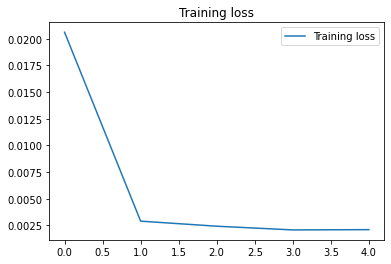

In [64]:
# Plotting the loss function
plt.plot(hist.history['loss'], label='Training loss')
plt.title("Training loss")
plt.legend()

In [65]:
# Predicting the train and test values
train_predict=model.predict(X_train_reshaped)
test_predict=model.predict(X_test_reshaped)

In [66]:
#Inverse transforming the values to regain the unscaled values
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

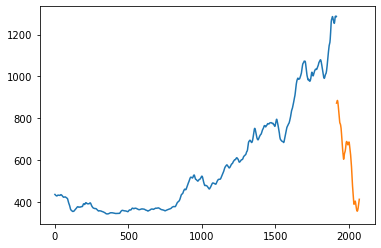

In [67]:
#Plotting the train and test values
day_new=np.arange(len(train_predict))
day_pred=np.arange(len(train_predict),len(train_predict)+len(test_predict))
plt.plot(day_new,train_predict)
plt.plot(day_pred,test_predict)

In [70]:
# Created a function to evaluate the metrics of all the models

def Evaluate_models(model):
    y_pred = model.predict(X_test_reshaped)
    
    MSE = mean_squared_error(Y_test, y_pred)
    
    RMSE = mean_squared_error(Y_test, y_pred, squared=False)

    R2 = r2_score(Y_test, y_pred)
    
    ADJ_R2 = 1 - (1-R2)*(len(Y_train)-1)/(X_train.shape[0]-X_train.shape[1]-1)

    MAPE = mean_absolute_percentage_error(Y_test, y_pred)
    
    return (MSE,RMSE,R2,ADJ_R2,MAPE)

In [73]:
# Loading the metrics into DF using above function
Metrics_LSTM  = Evaluate_models(model_LSTM)
MSE_LSTM = Metrics_LSTM[0]
RMSE_LSTM = Metrics_LSTM[1]
R2_LSTM = Metrics_LSTM[2]
ADJ_R2_LSTM = Metrics_LSTM[3]
MAPE_LSTM = Metrics_LSTM[4]

In [74]:
Metrics={'Models':["Neural Network"],
      'MSE' :[MSE_LSTM],
      'RMSE' :[RMSE_LSTM],
      'R2' :[R2_LSTM],
      'ADJ R2' :[ADJ_R2_LSTM,],
      'MAPE' :[MAPE_LSTM]
      
   }
Metrics=pd.DataFrame(Metrics)
# Saving the DF into CSV file
Metrics.to_csv("Metrics.csv")

In [75]:
Metrics

,Models,MSE,RMSE,R2,ADJ R2,MAPE
0,Neural Network,0.004493,0.067029,0.780818,0.770015,3.496228e+12
